# Full Notebook: https://nbviewer.org/github/beridzeg45/Exploratory-Data-Analysis-with-Python/blob/main/USA%20population%20analysis%20%28Geopandas%2C%20Plotly%29.ipynb 

In [1]:
import pandas as pd
import numpy as np
import geopandas
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns

In [2]:
plt.style.use('ggplot')

In [3]:
%%time

df=pd.read_csv(r'csv_files/pop-by-zip-code.csv')
states=geopandas.read_file(r"C:\Users\berid\python\geopandas\s_22mr22_states\s_22mr22.shp")
zips=geopandas.read_file(r"C:\Users\berid\python\geopandas\tl_2019_us_zcta510_zipcodes\tl_2019_us_zcta510.shp")
world=geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

CPU times: total: 1min 54s
Wall time: 1min 58s


In [4]:
df['zip_code']=df['zip_code'].apply(lambda x:'00'+str(x) if len(str(x))==3 else
                    '0'+str(x) if len(str(x))==4 else str(x))
df['zip_code']=df['zip_code'].str.strip()

In [5]:
df

zip_code       lat        lng         city state_id  y-2016  y-2015  \
0        00601  18.18027  -66.75266     Adjuntas       PR   17800   17982   
1        00602  18.36075  -67.17541       Aguada       PR   39716   40260   
2        00603  18.45744  -67.12225    Aguadilla       PR   51565   52408   
3        00606  18.16585  -66.93716      Maricao       PR    6320    6331   
4        00610  18.29110  -67.12243       Anasco       PR   27976   28328   
...        ...       ...        ...          ...      ...     ...     ...   
33115    99923  55.98043 -130.03803        Hyder       AK       0      13   
33116    99925  55.55398 -132.96276      Klawock       AK     908     826   
33117    99926  55.12617 -131.48928   Metlakatla       AK    1667    1711   
33118    99927  56.33305 -133.60044  Point Baker       AK      81     123   
33119    99929  56.36089 -132.00635     Wrangell       AK    2385    2365   

       y-2014  y-2013  y-2012  y-2011  y-2010  aggregate  
0       18088   18450   18544   18533   18570     127967  
1       40859   41302   41640   41930   41520     287227  
2       53162   53683   54540   54475   54689     374522  
3        6415    6591    6593    6386    6615      45251  
4       28805   28963   29141   29111   29016     201340  
...       ...     ...     ...     ...     ...        ...  
33115      12      81      77     116      87        386  
33116     728     668     673     689     819       5311  
33117    1622    1630    1624    1488    1460      11202  
33118     131     111      75      67      94        682  
33119    2354    2341    2361    2321    2338      16465  

[33120 rows x 13 columns]

In [6]:
years=sorted(df.columns[df.columns.str.startswith('y')])

In [7]:
for year in years:
    df[year]=df[year].replace(0,np.nan)

In [8]:
df=df.merge(zips[['GEOID10','geometry']],left_on='zip_code',right_on='GEOID10')
df=geopandas.GeoDataFrame(df)

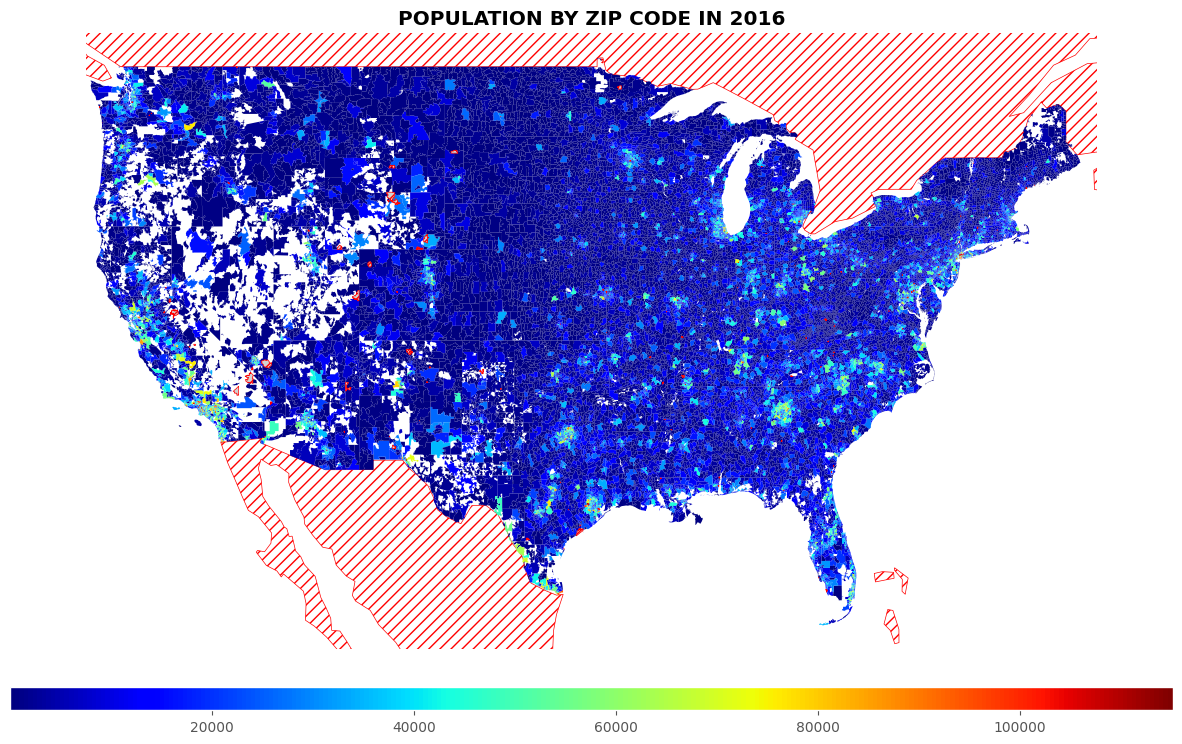




CPU times: total: 44.1 s
Wall time: 1min 6s


In [17]:
%%time
for year in ['y-2016']:
    fig,ax=plt.subplots(figsize=(15,10))
    world.query('name!="United States of America"').plot(ax=ax,color='white',ec='red',hatch="///")
    df.plot(ax=ax,column=df[year],cmap='jet',legend=True,
            legend_kwds={'orientation':'horizontal','aspect':50,'pad':0.05},
            missing_kwds={"color": "lightgrey", "edgecolor": "red", "hatch": "///", "label": "Missing values"})

    ax.set_title(f"POPULATION BY ZIP CODE IN {year.replace('y-','')}",fontweight='bold')
    ax.set_xlim(-125,-66)
    ax.set_ylim(23.5,50.5)
    ax.axis('off')
    plt.show()
    print('\n\n')

In [10]:
g=df.groupby(['state_id','city']).agg({'y-2010':'sum','y-2016':'sum','lat':'median','lng':'median'}).reset_index()
states=states.query('-125<LON<-66 and 23<LAT<50').reset_index(drop=True)

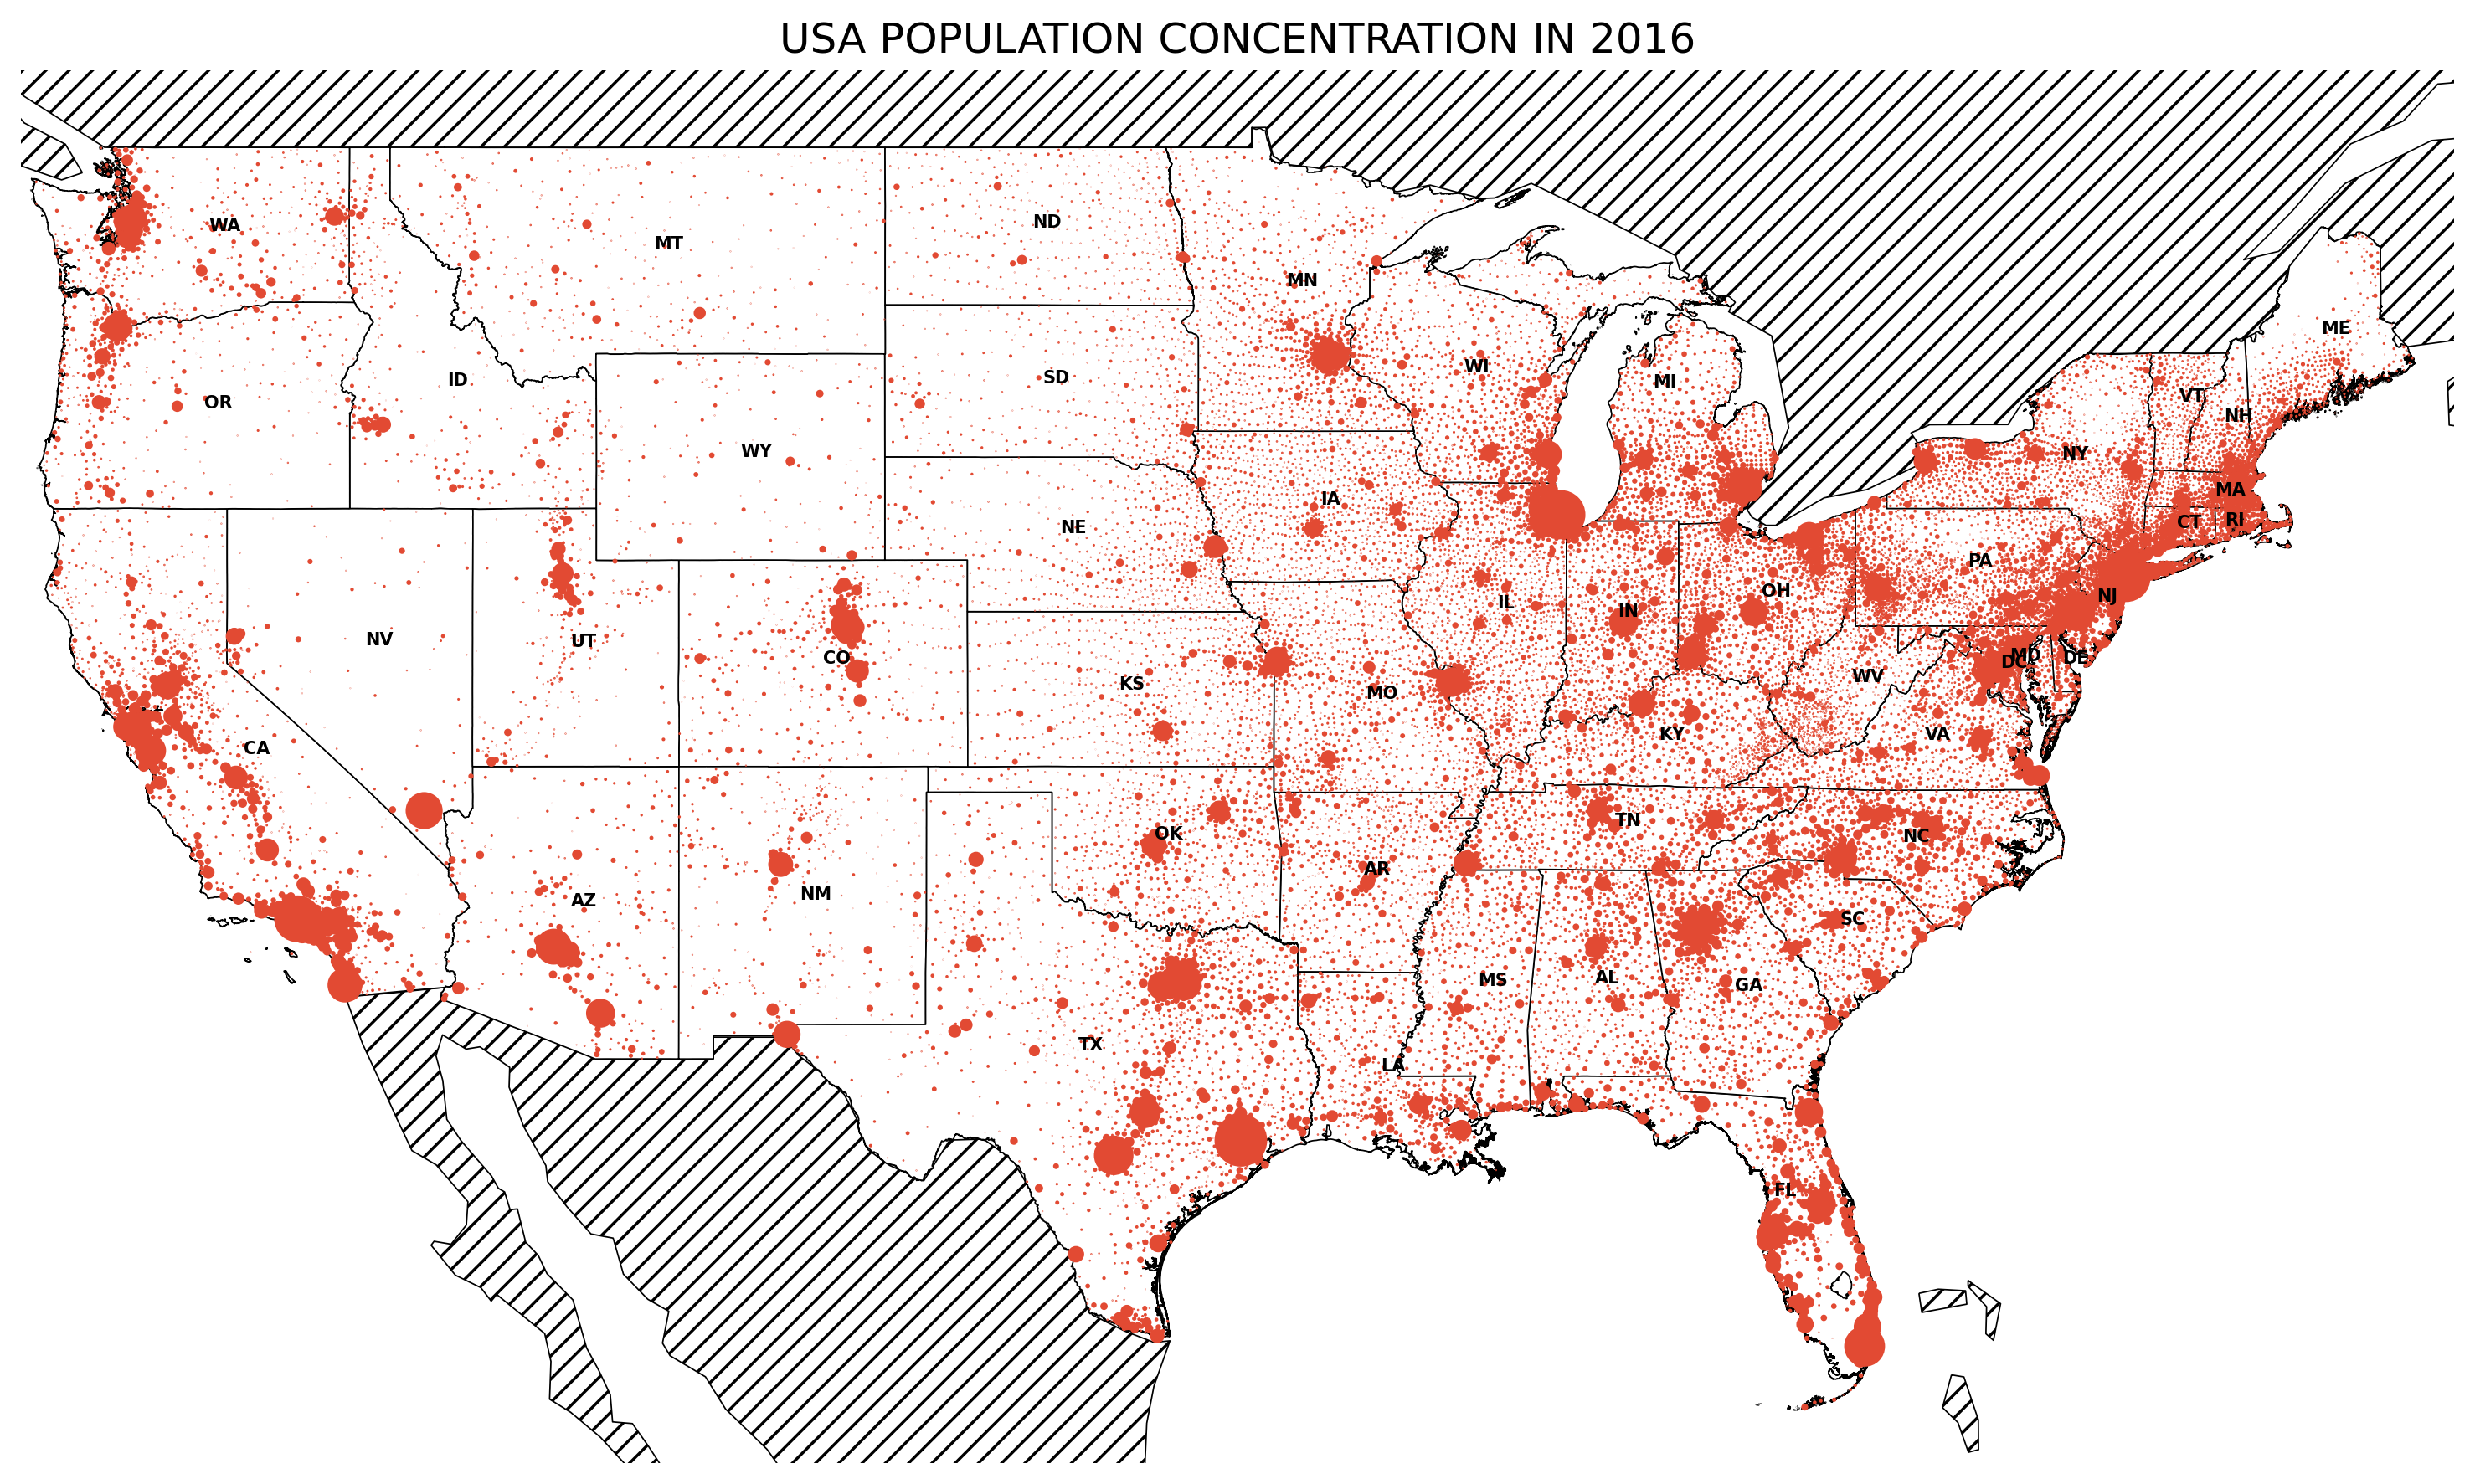

In [11]:
fig,ax=plt.subplots(figsize=(15,10),dpi=250)
world.query('name!="United States of America"').plot(ax=ax,color='white',ec='black',hatch="///")
states.plot(ax=ax,color='w',ec='k')
ax.scatter(g['lng'],g['lat'],s=g['y-2016']/10**4)
for i in range(len(states)):
    ax.text(states['LON'][i],states['LAT'][i],states['STATE'][i],fontweight='bold',size=6)
ax.set_title('USA POPULATION CONCENTRATION IN 2016')
ax.set_xlim(-125,-66)
ax.set_ylim(23.5,50.5)
ax.axis('off')
plt.show()

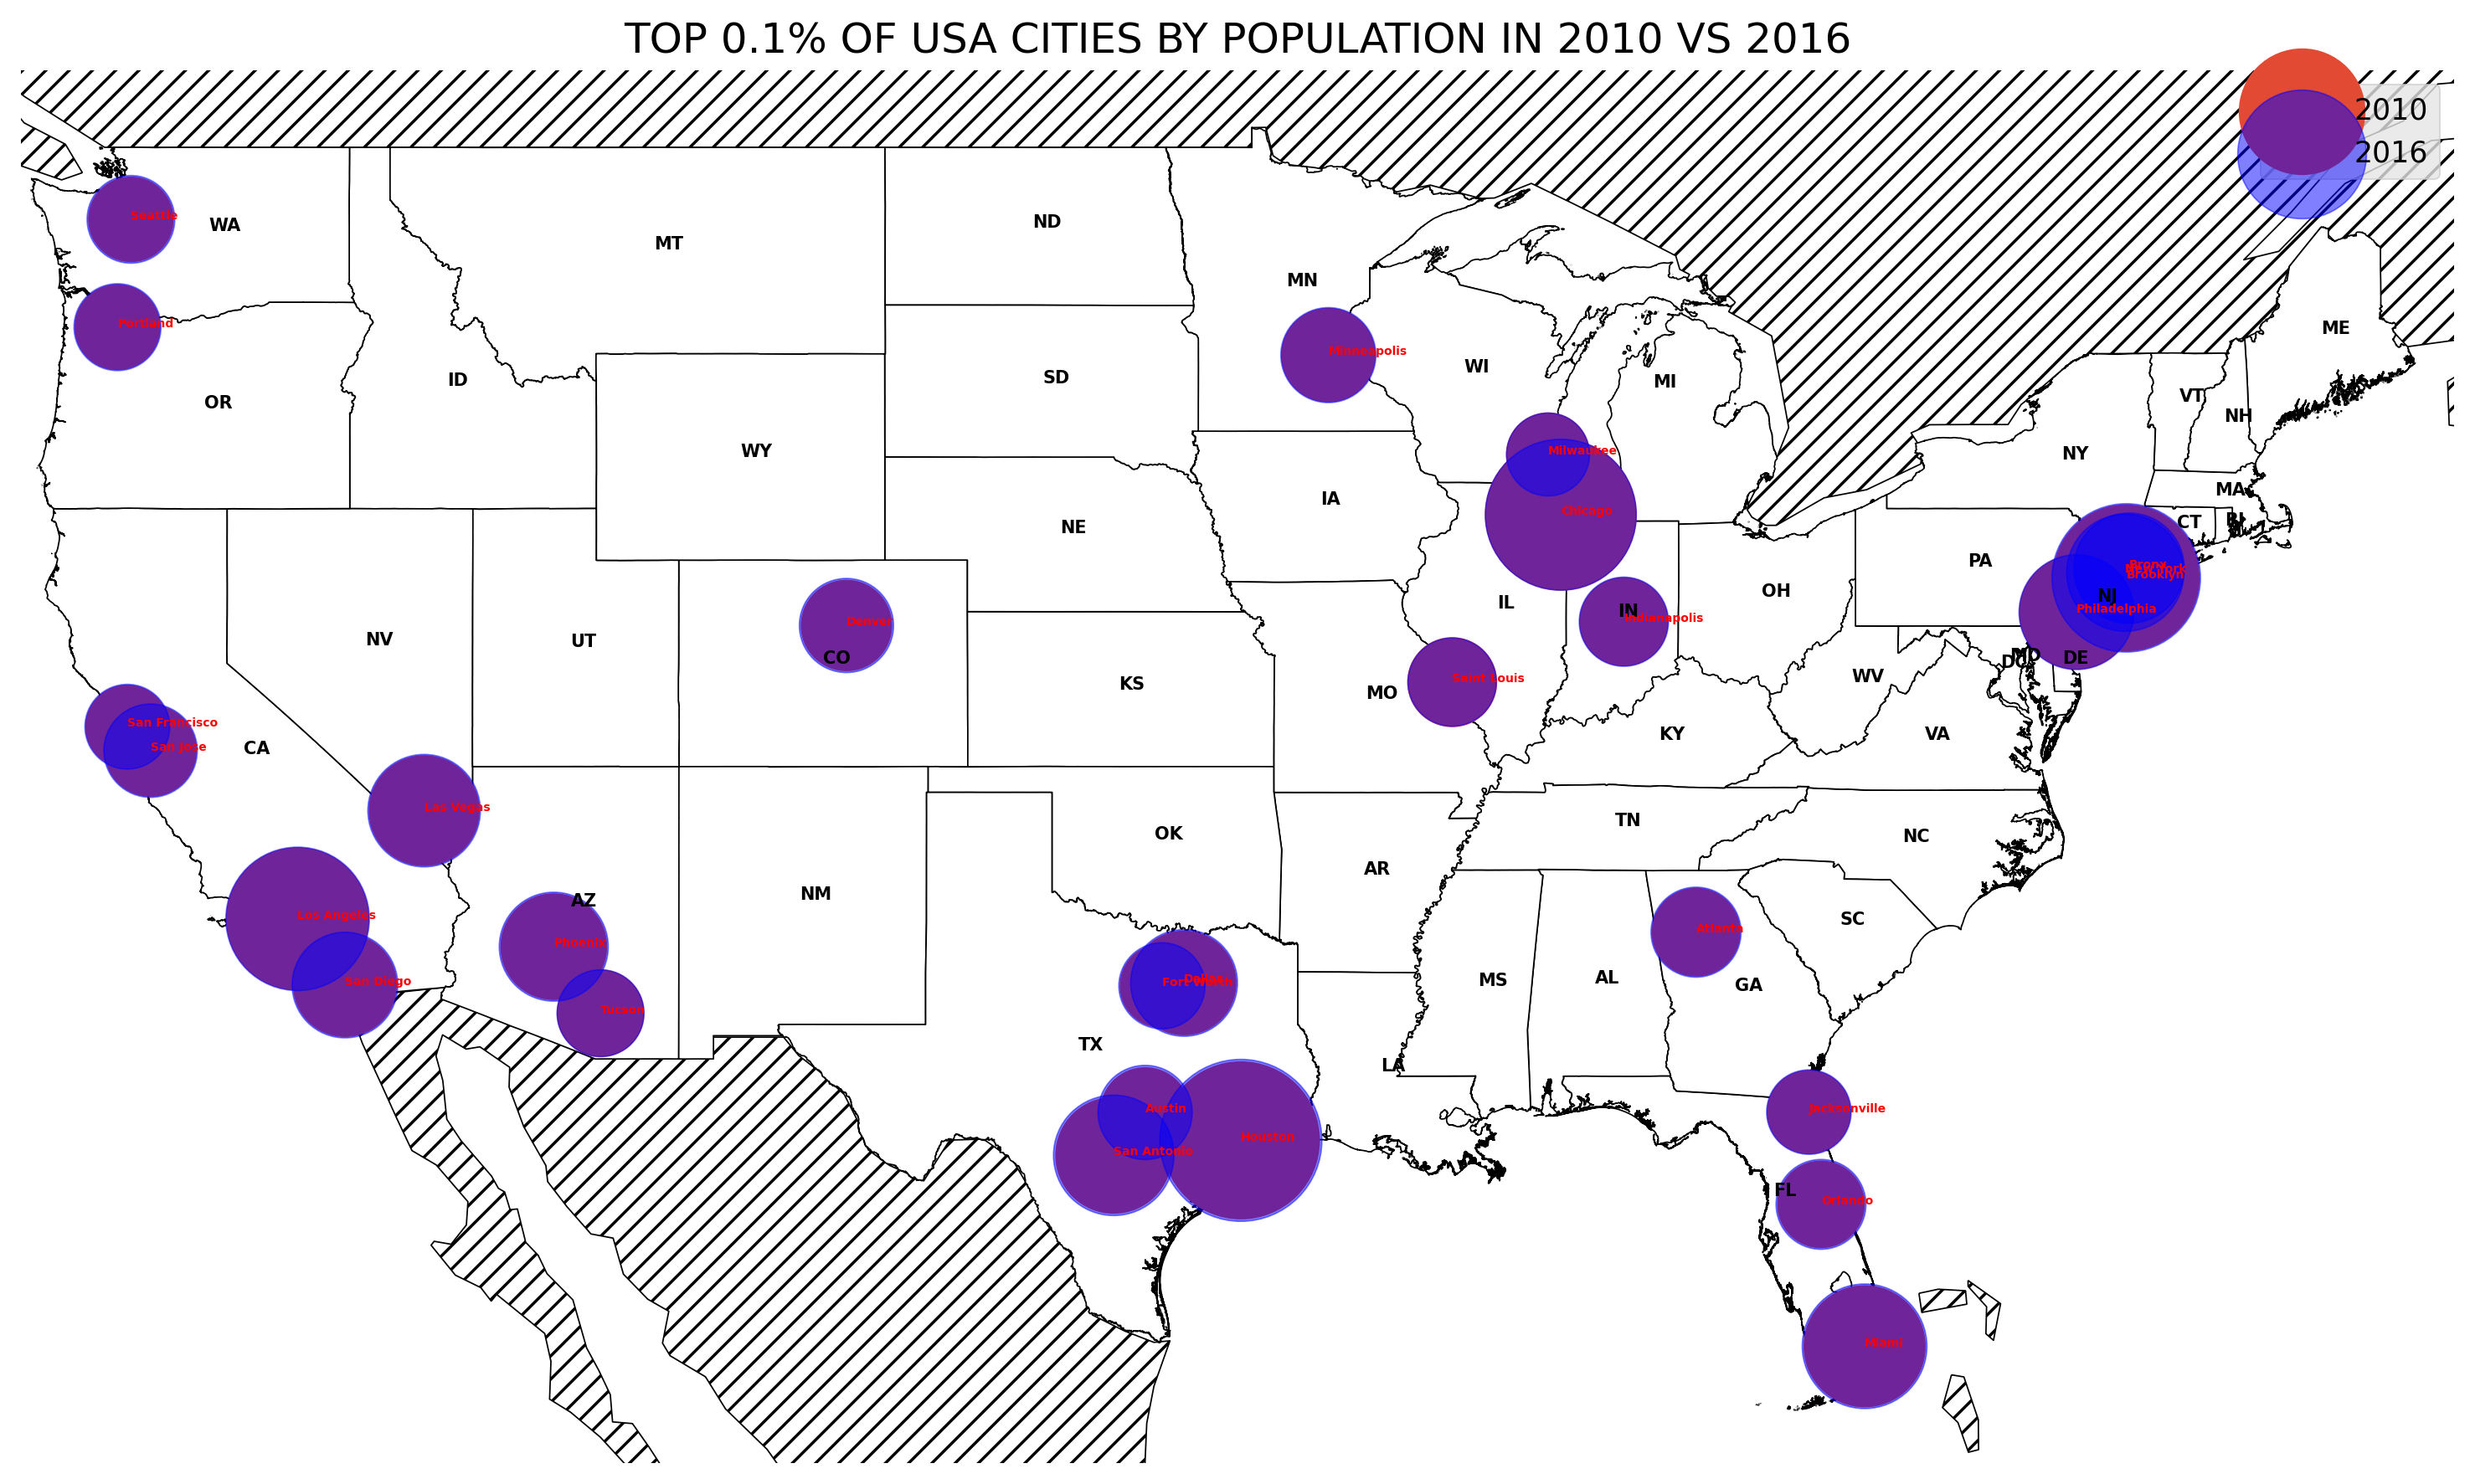

In [15]:
fig,ax=plt.subplots(figsize=(15,10),dpi=250)
top=g[g['y-2010']>=g['y-2010'].quantile(0.999)].reset_index(drop=True) # top 0.1% percent of USA cities by population
world.query('name!="United States of America"').plot(ax=ax,color='white',ec='black',hatch="///")
states.plot(ax=ax,color='w',ec='k')
ax.scatter(top['lng'],top['lat'],s=top['y-2010']/10**3,label='2010')
ax.scatter(top['lng'],top['lat'],s=top['y-2016']/10**3,label='2016',c='b',alpha=0.5)
for i in range(len(states)):
    ax.text(states['LON'][i],states['LAT'][i],states['STATE'][i],fontweight='bold',size=6)
for i in range(len(top)):
    ax.text(top['lng'][i],top['lat'][i],top['city'][i],fontweight='bold',size=4,color='red')
ax.set_title('TOP 0.1% OF USA CITIES BY POPULATION IN 2010 VS 2016')
ax.set_xlim(-125,-66)
ax.set_ylim(23.5,50.5)
ax.axis('off')
ax.legend()
plt.show()

In [13]:
# population for top 0.1% of USA cities did not change significantly between 2010 and 2016

In [16]:
g=df.groupby('state_id')[['y-2010','y-2011','y-2012','y-2013','y-2014','y-2015','y-2016']].sum().reset_index()
g['change_2010_2016']=(g['y-2016']-g['y-2010'])/g['y-2010']*100

fig=make_subplots(specs=[[{'secondary_y':True}]])
trace11=go.Bar(x=g['state_id'],y=g['y-2010'],name='2010')
trace12=go.Bar(x=g['state_id'],y=g['y-2016'],name='2016')
trace2=go.Line(x=g['state_id'],y=g['change_2010_2016'],name='Change',mode='lines+markers')

fig.add_trace(trace11,secondary_y=False)
fig.add_trace(trace12,secondary_y=False)
fig.add_trace(trace2,secondary_y=True)


fig.update_layout(title=dict(text='US POPULATION BY STATE in 2010 vs 2016',font_family='Arial Black'),hovermode='x unified')
fig.update_yaxes(title='Population')
fig.update_yaxes(title='Change of population(%)',secondary_y=True)
fig.update_xaxes(title='State')
fig.show()

C:\Users\berid\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


